In [91]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import datetime
import matplotlib.pyplot as plt
import haversine

import centered_response as cr

In [92]:
#case = '201905172100'
#case = '201905172200'
#case = '201905202030'
#case = '201905262000'
case = '201905282230'

# Define case specs
wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)

respout_dir = '/Users/williamfaletti/Documents/python/thesis/wofs_code/respout_center'

In [93]:
%%capture

df = cr.create_coords_df(file_resp_coords, file_mrms_maxima) # 5-min response interval

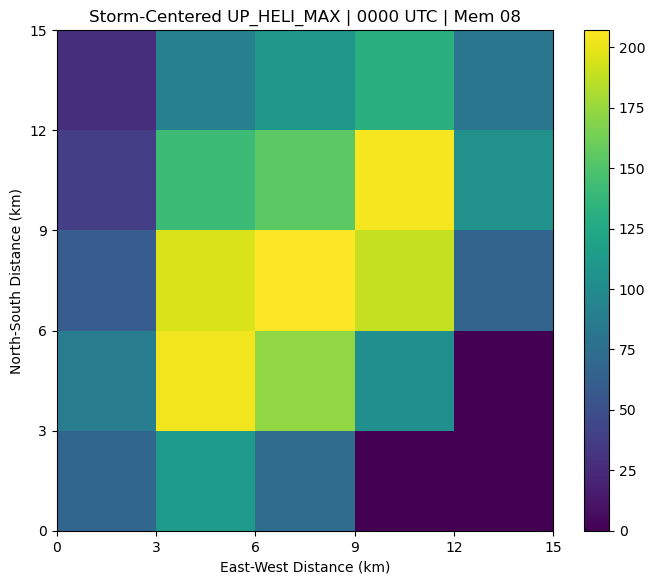

In [94]:
cr.varvis_c(file_latlons, df, '290000', mem=8, var='UP_HELI_MAX')

In [95]:
files = files_wofs

uhmax_time, wzmax_time, wmax_time, time = [],[],[],[]
for i, (nycol, nxcol) in enumerate(zip(df.columns[0::2], df.columns[1::2])):

    ds = xr.open_dataset(files[i])
    
    uh_max, wz_max, w_max = [],[],[]
    
    for mem in range(36):
    
        center_ny = df[nycol].values[mem]
        center_nx = df[nxcol].values[mem]

        if center_ny < 0:
            uh_max.append(0.0)
            wz_max.append(0.0)
            w_max.append(0.0)
            continue
        
        max_uh = float(ds['UP_HELI_MAX'][mem,0,center_ny,center_nx].values)
        
        max_wz = float(np.nanmax(ds['WZ_25'][mem,0,center_ny-2:center_ny+3,center_nx-2:center_nx+3]))
        
        max_w = float(np.nanmax(ds['W_UP_MAX'][mem,0,center_ny-2:center_ny+3,center_nx-2:center_nx+3]))
        
        uh_max.append(max_uh)
        wz_max.append(max_wz)
        w_max.append(max_w)
    
    uhmax_time.append(uh_max)
    wzmax_time.append(wz_max)
    wmax_time.append(w_max)
    time.append(nxcol[:8])


0035 UTC


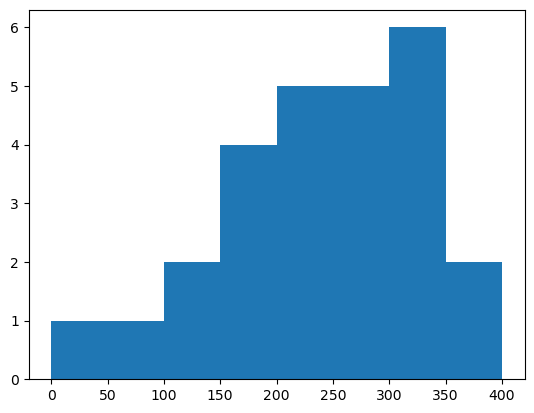

In [96]:
idx=-6

plt.hist(uhmax_time[idx], bins=np.arange(0,450,50))
print(time[idx])

In [13]:
# Save UH response functions to file

#resp_60 = np.nanmax(uhmax_time, axis=0)
resp_30 = np.nanmax(uhmax_time[-7:], axis=0)
resp_15 = np.nanmax(uhmax_time[-4:], axis=0)
resp_05 = np.array(uhmax_time[-1])

#ds_respout_60 = xr.Dataset(
#     data_vars=dict(
#         UH25_60MIN=(['NE'], resp_60),
#     ),
#        attrs=dict(DX = '3000',
#                   DY = '3000',
#                   RF_CENTER_LON = np.nan,
#                   RF_CENTER_LAT = np.nan,
#                   RF_X_LEFT = np.nan,
#                   RF_X_RIGHT = np.nan,
#                   RF_Y_BOTTOM = np.nan,
#                   RF_Y_TOP = np.nan,
#                   RESP_VAR = 'UH25_60MIN',
#                   RESP_TIME = resptime,
#                   METHOD = 'max')
#)

ds_respout_30 = xr.Dataset(
     data_vars=dict(
         UH25_30MIN=(['NE'], resp_30),
     ),
        attrs=dict(DX = '3000',
                   DY = '3000',
                   RF_CENTER_LON = np.nan,
                   RF_CENTER_LAT = np.nan,
                   RF_X_LEFT = np.nan,
                   RF_X_RIGHT = np.nan,
                   RF_Y_BOTTOM = np.nan,
                   RF_Y_TOP = np.nan,
                   RESP_VAR = 'UH25_30MIN',
                   RESP_TIME = resptime,
                   METHOD = 'max')
)

ds_respout_15 = xr.Dataset(
     data_vars=dict(
         UH25_15MIN=(['NE'], resp_15),
     ),
        attrs=dict(DX = '3000',
                   DY = '3000',
                   RF_CENTER_LON = np.nan,
                   RF_CENTER_LAT = np.nan,
                   RF_X_LEFT = np.nan,
                   RF_X_RIGHT = np.nan,
                   RF_Y_BOTTOM = np.nan,
                   RF_Y_TOP = np.nan,
                   RESP_VAR = 'UH25_15MIN',
                   RESP_TIME = resptime,
                   METHOD = 'max')
)

ds_respout_05 = xr.Dataset(
     data_vars=dict(
         UH25_05MIN=(['NE'], resp_05),
     ),
        attrs=dict(DX = '3000',
                   DY = '3000',
                   RF_CENTER_LON = np.nan,
                   RF_CENTER_LAT = np.nan,
                   RF_X_LEFT = np.nan,
                   RF_X_RIGHT = np.nan,
                   RF_Y_BOTTOM = np.nan,
                   RF_Y_TOP = np.nan,
                   RESP_VAR = 'UH25_05MIN',
                   RESP_TIME = resptime,
                   METHOD = 'max')
)

#ds_respout_60.to_netcdf(path=f'{respout_dir}/resp_{ds_respout_60.RESP_VAR}_{ds_respout_60.METHOD}_{ds_respout_60.RESP_TIME}.nc')
#ds_respout_30.to_netcdf(path=f'{respout_dir}/resp_{ds_respout_30.RESP_VAR}_{ds_respout_30.METHOD}_{ds_respout_30.RESP_TIME}_2200.nc')
#ds_respout_15.to_netcdf(path=f'{respout_dir}/resp_{ds_respout_15.RESP_VAR}_{ds_respout_15.METHOD}_{ds_respout_15.RESP_TIME}_2200.nc')
#ds_respout_05.to_netcdf(path=f'{respout_dir}/resp_{ds_respout_05.RESP_VAR}_{ds_respout_05.METHOD}_{ds_respout_05.RESP_TIME}_2200.nc')


In [14]:
# Save vorticity response functions to file

#resp_60 = np.nanmax(wzmax_time, axis=0)
resp_30 = np.nanmax(wzmax_time[-7:], axis=0)
resp_15 = np.nanmax(wzmax_time[-4:], axis=0)
resp_05 = np.array(wzmax_time[-1])

#ds_respout_60 = xr.Dataset(
#     data_vars=dict(
#         WZ25_60MIN=(['NE'], resp_60),
#     ),
#        attrs=dict(DX = '3000',
#                   DY = '3000',
#                   RF_CENTER_LON = np.nan,
#                   RF_CENTER_LAT = np.nan,
#                   RF_X_LEFT = np.nan,
#                   RF_X_RIGHT = np.nan,
#                   RF_Y_BOTTOM = np.nan,
#                   RF_Y_TOP = np.nan,
#                   RESP_VAR = 'WZ25_60MIN',
#                   RESP_TIME = resptime,
#                   METHOD = 'max')
#)

ds_respout_30 = xr.Dataset(
     data_vars=dict(
         WZ25_30MIN=(['NE'], resp_30),
     ),
        attrs=dict(DX = '3000',
                   DY = '3000',
                   RF_CENTER_LON = np.nan,
                   RF_CENTER_LAT = np.nan,
                   RF_X_LEFT = np.nan,
                   RF_X_RIGHT = np.nan,
                   RF_Y_BOTTOM = np.nan,
                   RF_Y_TOP = np.nan,
                   RESP_VAR = 'WZ25_30MIN',
                   RESP_TIME = resptime,
                   METHOD = 'max')
)

ds_respout_15 = xr.Dataset(
     data_vars=dict(
         WZ25_15MIN=(['NE'], resp_15),
     ),
        attrs=dict(DX = '3000',
                   DY = '3000',
                   RF_CENTER_LON = np.nan,
                   RF_CENTER_LAT = np.nan,
                   RF_X_LEFT = np.nan,
                   RF_X_RIGHT = np.nan,
                   RF_Y_BOTTOM = np.nan,
                   RF_Y_TOP = np.nan,
                   RESP_VAR = 'WZ25_15MIN',
                   RESP_TIME = resptime,
                   METHOD = 'max')
)

ds_respout_05 = xr.Dataset(
     data_vars=dict(
         WZ25_05MIN=(['NE'], resp_05),
     ),
        attrs=dict(DX = '3000',
                   DY = '3000',
                   RF_CENTER_LON = np.nan,
                   RF_CENTER_LAT = np.nan,
                   RF_X_LEFT = np.nan,
                   RF_X_RIGHT = np.nan,
                   RF_Y_BOTTOM = np.nan,
                   RF_Y_TOP = np.nan,
                   RESP_VAR = 'WZ25_05MIN',
                   RESP_TIME = resptime,
                   METHOD = 'max')
)

#ds_respout_60.to_netcdf(path=f'respout_center/resp_{ds_respout_60.RESP_VAR}_{ds_respout_60.METHOD}_{ds_respout_60.RESP_TIME}.nc')
ds_respout_30.to_netcdf(path=f'respout_center/resp_{ds_respout_30.RESP_VAR}_{ds_respout_30.METHOD}_{ds_respout_30.RESP_TIME}_2200.nc')
ds_respout_15.to_netcdf(path=f'respout_center/resp_{ds_respout_15.RESP_VAR}_{ds_respout_15.METHOD}_{ds_respout_15.RESP_TIME}_2200.nc')
ds_respout_05.to_netcdf(path=f'respout_center/resp_{ds_respout_05.RESP_VAR}_{ds_respout_05.METHOD}_{ds_respout_05.RESP_TIME}_2200.nc')

### Plot sensitivity

In [7]:
%%capture

# Set initialization time
init_time = datetime.datetime(2019,5,28,22,30)
state_time = datetime.datetime(2019,5,29,0,0)
resp_time = init_time + datetime.timedelta(hours=2.5)

statevar, respvar = 'V10','UH25-05MIN'

str_respmin, str_resphour, str_respmonth = '{:02d}'.format(resp_time.minute),'{:02d}'.format(resp_time.hour),'{:02d}'.format(resp_time.month)
str_statemin, str_statehour, str_statemonth = '{:02d}'.format(state_time.minute),'{:02d}'.format(state_time.hour),'{:02d}'.format(state_time.month)
str_initmin, str_inithour, str_initmonth = '{:02d}'.format(init_time.minute),'{:02d}'.format(init_time.hour),'{:02d}'.format(init_time.month)

file_sens = f'/Volumes/faletti_backup/sens_out/sens_center_2019{str_initmonth}{init_time.day}{str_inithour}{str_initmin}/stats_{respvar}_max_{str_resphour}_{str_respmin}_00_{statevar}_{str_statehour}_{str_statemin}_00.nc'
file_ref = f'/Volumes/faletti_backup/WOFS_output/wofs_{init_time.year}{str_initmonth}{init_time.day}_{str_inithour}{str_initmin}/wofs_center_i{init_time.year}{str_initmonth}{init_time.day}{str_inithour}{str_initmin}_v{state_time.year}{str_statemonth}{state_time.day}{str_statehour}{str_statemin}.nc'

ds_sens = xr.open_dataset(file_sens)
ds_ref = xr.open_dataset(file_ref)

sens = ds_sens.sens
cref = np.where(np.nanmean(ds_ref.REFD_MAX, axis=0) < 10, np.nan, np.nanmean(ds_ref.REFD_MAX, axis=0))

df_center = cr.create_mrmscenter_df(file_coords, file_mrms_maxima)

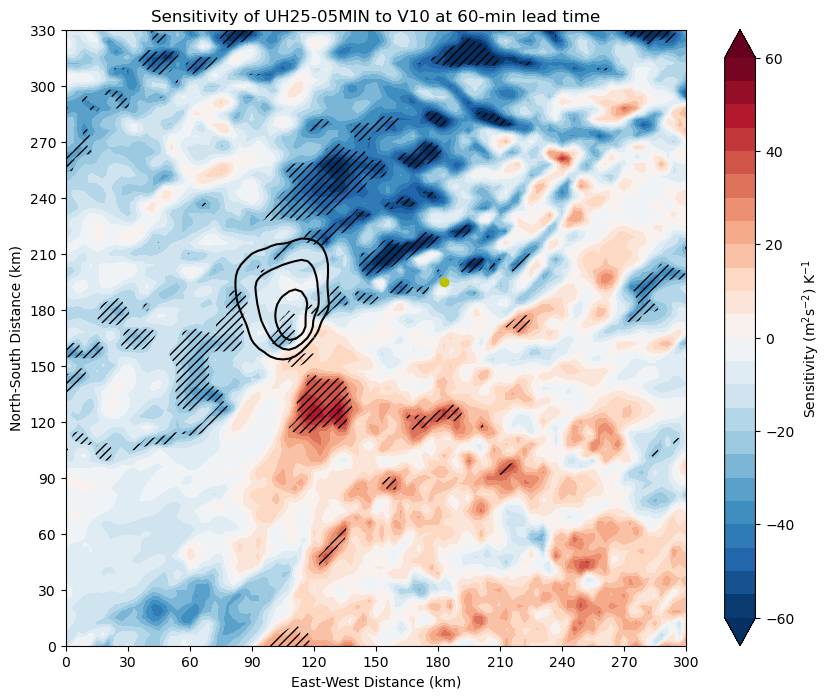

In [8]:
fig = plt.figure(figsize=(10,8))

levels = np.arange(-60,61,5)
ticks = levels[0::4]

cb = plt.contourf(np.nanmean(ds_ref.T2,axis=0)[0], levels=40,cmap='Blues')
plt.contour(cref[0], levels=[20,35,50], colors='k')
cb = plt.contourf(sens, cmap='RdBu_r', levels=levels, extend='both')
plt.contourf(abs(ds_sens['pstat'].values), [0, 0.05], colors='none', hatches=['////'], extend='lower')

plt.scatter(62,175, c='y')

#plt.pcolormesh(sens, cmap='bwr', vmin=-60, vmax=60)
plt.colorbar(cb, label='Sensitivity (m$^{2}$s$^{-2}$) K$^{-1}$', ticks=ticks)

xcenter,ycenter = int(df_center[f'{str_statehour}{str_statemin} UTC ny'].values), int(df_center[f'{str_statehour}{str_statemin} UTC nx'].values)

xlimleft, xlimright = -40,60
ylimleft, ylimright = -60,50

plt.xlim(xcenter+xlimleft, xcenter+xlimright)
plt.ylim(ycenter+ylimleft,ycenter+ylimright)

xtickpos, ytickpos = np.arange(xcenter+xlimleft, xcenter+xlimright+1 ,10), np.arange(ycenter+ylimleft, ycenter+ylimright+1, 10)
xticklabels, yticklabels = np.arange(0, len(xtickpos)*30 - 1, 30), np.arange(0,len(ytickpos)*30 - 1, 30)

plt.xticks(xtickpos, labels=xticklabels)
plt.yticks(ytickpos, labels=yticklabels)

plt.xlabel('East-West Distance (km)')
plt.ylabel('North-South Distance (km)')
plt.title(f'Sensitivity of {respvar} to {statevar} at {int((resp_time - state_time).seconds/60)}-min lead time')

plt.show()

In [12]:
ds_resp=xr.open_dataset(f'respout_center/resp_UH25_05MIN_max_2019-05-29_01_00_00.nc')

[88.69351959228516,
 462.53131103515625,
 272.1445617675781,
 348.8865661621094,
 167.52613830566406,
 221.10736083984375,
 328.2065734863281,
 218.0568389892578,
 341.356201171875,
 692.883056640625,
 372.25738525390625,
 189.0950469970703,
 322.7196350097656,
 515.6499633789062,
 372.6179504394531,
 247.57467651367188,
 170.46804809570312,
 283.1093444824219,
 219.67018127441406,
 449.3163146972656,
 161.15188598632812,
 332.7645568847656,
 156.01559448242188,
 558.4024658203125,
 322.614990234375,
 528.3099365234375,
 327.39031982421875,
 439.140625,
 502.4801025390625,
 393.8259582519531,
 250.0347900390625,
 603.433837890625,
 446.416748046875,
 223.3880615234375,
 0.0,
 290.8033447265625]

Text(0.5, 1.0, 'Mesocyclone Intensity at Response vs. Lead Time')

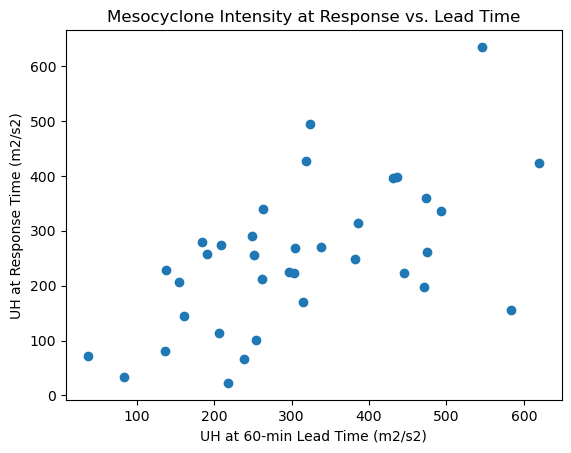

In [23]:
plt.scatter(uhmax_time[-6], uhmax_time[-1])
#plt.xlim(-20, 800)
#plt.ylim(-20, 800)

plt.xlabel('UH at 60-min Lead Time (m2/s2)')
plt.ylabel('UH at Response Time (m2/s2)')
plt.title('Mesocyclone Intensity at Response vs. Lead Time')

In [33]:
ysu=[0,1,6,7,12,13,22,23,28,29,34,35]
myj=[2,3,8,9,14,15,20,21,26,27,32,33]
mynn=[4,5,10,11,16,17,18,19,24,25,30,31]

Text(0, 0.5, 'Updraft Helicity (m2/s2)')

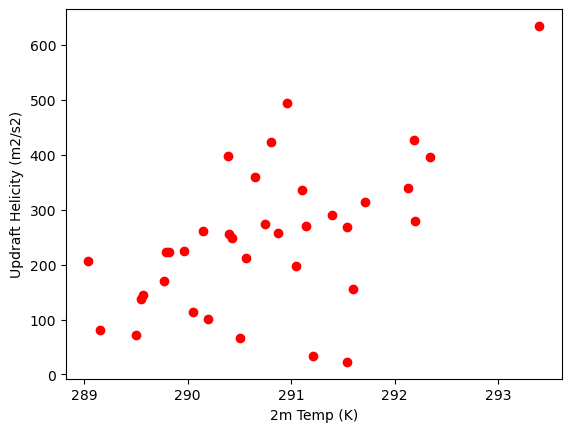

In [84]:
plt.scatter(ds_ref.T2[:,0,175,62].values[:],ds_resp.UH25_05MIN.values[:], c='red')
#plt.scatter(ds_ref.SHEAR_TOT1[:,0,175,62].values[myj],ds_resp.UH25_05MIN.values[myj], c='blue')
#plt.scatter(ds_ref.SHEAR_TOT1[:,0,175,62].values[mynn],ds_resp.UH25_05MIN.values[mynn], c='green')

plt.xlabel('2m Temp (K)')
plt.ylabel('Updraft Helicity (m2/s2)')

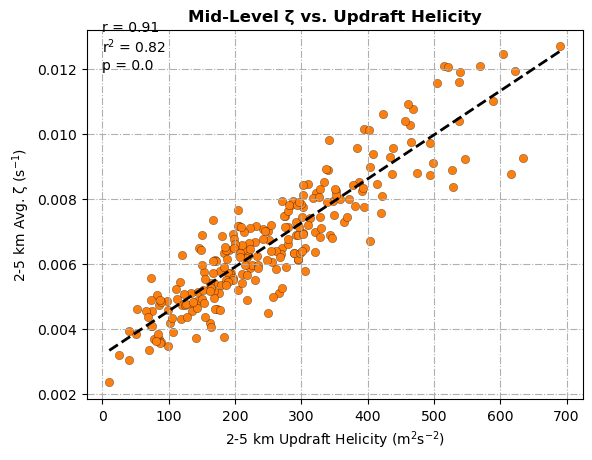

In [115]:
import scipy

fig = plt.figure()

m, b, r, p, std_err = scipy.stats.linregress(np.concatenate(uhmax_time), np.concatenate(wzmax_time))

plt.scatter(uhmax_time, np.array(wzmax_time), c='tab:orange', edgecolor='k', lw=0.20)
plt.plot(np.arange(np.min(uhmax_time), np.max(uhmax_time), 10), m*np.arange(np.min(uhmax_time), np.max(uhmax_time), 10)+b,
            c='k', lw=2, ls='--')

plt.annotate(f'r = {np.round(r,2)} \nr$^2$ = {np.round(r**2,2)} \np = {np.round(p,2)}' , (0,0.012))

plt.xlabel('2-5 km Updraft Helicity (m$^{2}$s$^{-2}$)')
plt.ylabel('2-5 km Avg. \u03B6 (s$^{-1}$)')
plt.grid(ls='-.')
plt.title('Mid-Level \u03B6 vs. Updraft Helicity', weight='bold')


plt.show()